In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import log_loss
from scipy.stats import gamma

#regionC---> divisoin ---> state ---> household (observed)


In [22]:
!pip install pymc==5.22.0


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [25]:
import pymc as pm
import arviz as az

## Empirical Bayes / Exploration Below

In [28]:
codebook = pd.read_csv('RECS 2020 Codebook for Public File - v7.csv').iloc[:,0:3]
energy = pd.read_csv('recs2020_public_v7.csv')
energy.head()
print(energy.columns)

Index(['DOEID', 'REGIONC', 'DIVISION', 'STATE_FIPS', 'state_postal',
       'state_name', 'BA_climate', 'IECC_climate_code', 'UATYP10', 'HDD65',
       ...
       'EVCHRGHOME', 'EVCHRGAPT', 'EVCHRGWKS', 'EVCHRGBUS', 'EVCHRGMUNI',
       'EVCHRGDLR', 'EVCHRGHWY', 'EVCHRGOTH', 'EVHOMEAMT', 'EVCHRGTYPE'],
      dtype='object', length=799)


Text(0.5, 1.0, 'KWH for California')

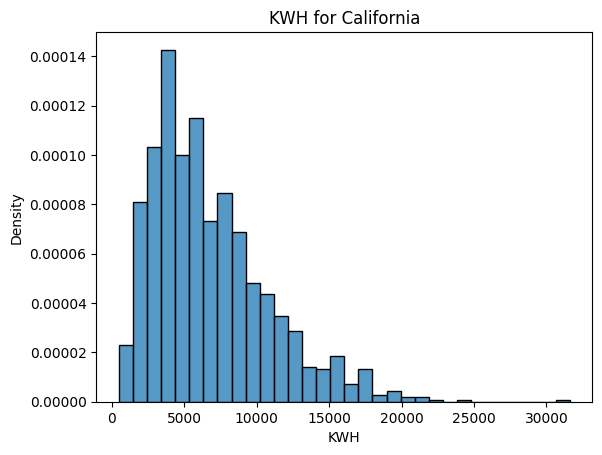

In [31]:
ca = energy[energy["state_name"]=="California"]
plt.figure()
sns.histplot(x = ca["KWH"], stat='density')
plt.title("KWH for California")

<AxesSubplot: xlabel='KWH', ylabel='Density'>

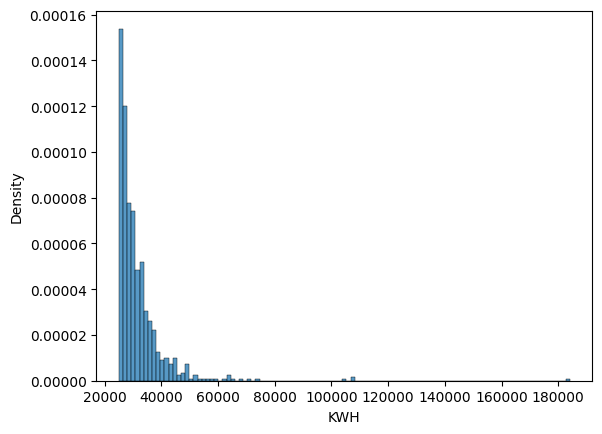

In [34]:
sns.histplot(energy[energy["KWH"] > 25000]["KWH"], stat="density")

In [37]:
country_wide_mean = energy["KWH"].mean()
country_wide_variance = energy["KWH"].var()
print("Country wide mean: ", country_wide_mean)
print("Country wide variance: ", country_wide_variance)

Country wide mean:  10848.818721885813
Country wide variance:  50577203.14904921


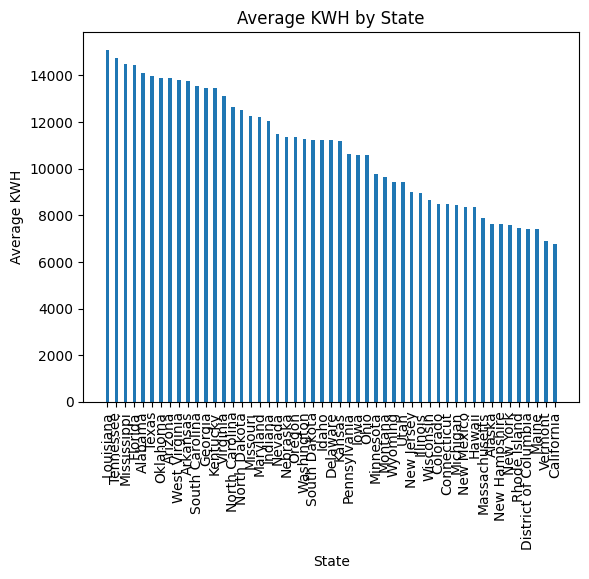

In [40]:
# mean on state lvl
state = energy[["state_name","KWH"]]
region_averages = state.groupby("state_name")["KWH"].agg("mean")
region_variance = state.groupby("state_name")["KWH"].var()
energy_state_m_v = pd.DataFrame()
energy_state_m_v["state_name"] = state["state_name"]
energy_state_m_v = pd.DataFrame({
    "state_mean": region_averages,
    "state_var": region_variance
}).reset_index()
energy_state_m_v = energy_state_m_v.sort_values("state_mean", ascending=False)

plt.bar(energy_state_m_v["state_name"],energy_state_m_v["state_mean"], width = 0.4)
plt.xticks(rotation=90)
plt.xlabel("State")
plt.ylabel("Average KWH")
plt.title("Average KWH by State")
#plt.tight_layout()
plt.show()

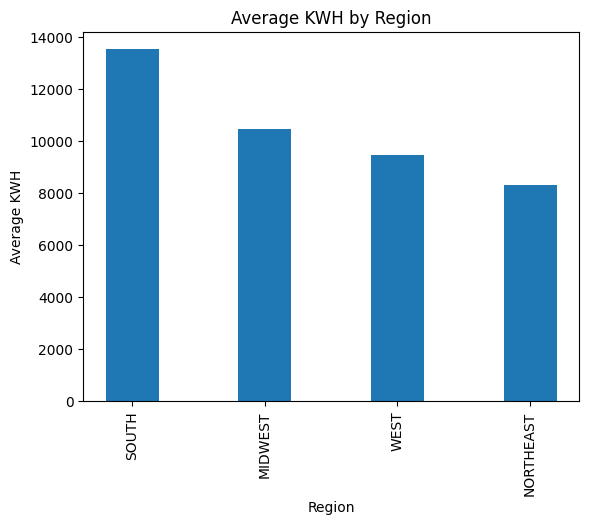

In [43]:

# mean on region lvl
energy_region = energy[["REGIONC","KWH"]]
region_averages = energy_region.groupby("REGIONC")["KWH"].agg("mean")
region_variance = energy_region.groupby("REGIONC")["KWH"].var()
energy_region_m_v = pd.DataFrame()
energy_region_m_v["REGIONC"] = energy_region["REGIONC"]
energy_region_m_v = pd.DataFrame({
    "region_mean": region_averages,
    "region_var": region_variance
}).reset_index()
energy_region_m_v = energy_region_m_v.sort_values("region_mean", ascending=False)

plt.bar(energy_region_m_v["REGIONC"],energy_region_m_v["region_mean"], width = 0.4)
plt.xticks(rotation=90)
plt.xlabel("Region")
plt.ylabel("Average KWH")
plt.title("Average KWH by Region")
#plt.tight_layout()
plt.show()

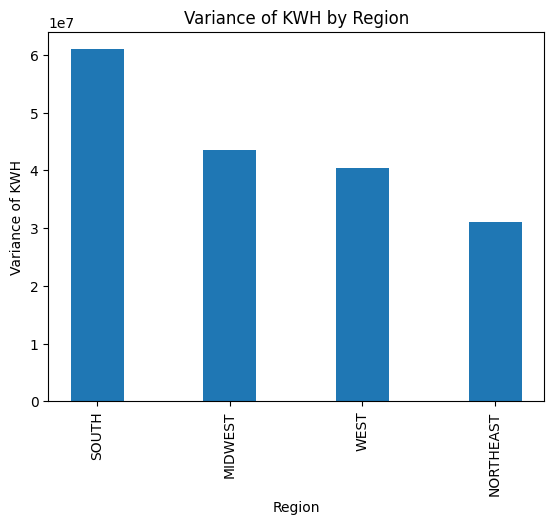

In [46]:
# variance on region lvl
energy_region_m_v = energy_region_m_v.sort_values("region_var", ascending=False)

plt.bar(energy_region_m_v["REGIONC"],energy_region_m_v["region_var"], width = 0.4)
plt.xticks(rotation=90)
plt.xlabel("Region")
plt.ylabel("Variance of KWH")
plt.title("Variance of KWH by Region")
#plt.tight_layout()
plt.show()

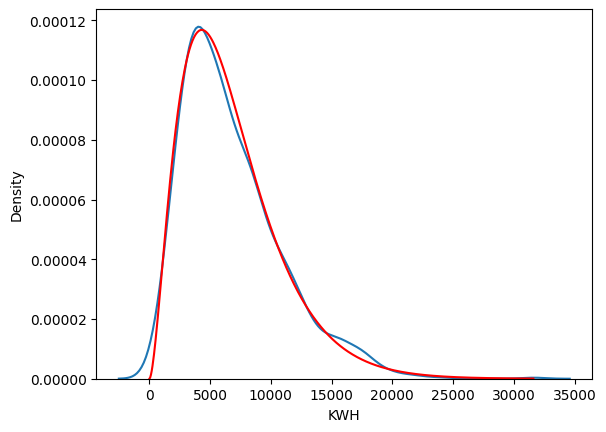

In [49]:
# gamma(r, lambda): mean = r/lambda, variance = r/(lambda**2)
# variance * (lambda**2) = r
# mean * lambda = r
# (variance / mean) * lambda = 1
# lambda = 1/(variance/mean), lambda = mean/variance
# mean * mean/variance = r
# (mean**2)/variance = r

def calc_r(mean, variance):
    return (mean**2) / var

def calc_lambda(mean, variance):
    return mean / var

state_rs = []
state_lambdas = []

for state in energy_state_m_v["state_name"]:
    s = energy_state_m_v[energy_state_m_v["state_name"] == state]
    mu = s["state_mean"].iloc[0]
    var = s["state_var"].iloc[0]
    state_rs.append(calc_r(mu, var))
    state_lambdas.append(calc_lambda(mu, var))

energy_state_m_v["state_r"] = state_rs
energy_state_m_v["state_lambda"] = state_lambdas
s = energy_state_m_v[energy_state_m_v["state_name"] == "California"]
mu = s["state_mean"].iloc[0]
var = s["state_var"].iloc[0]
plt.figure()
ca = energy[energy["state_name"]=="California"]["KWH"]
sns.kdeplot(ca)
x = np.linspace(0, ca.max(), 500)
y = gamma.pdf(x, a=calc_r(mu, var), scale=1/calc_lambda(mu, var))
plt.plot(x,y, color="red")

['SOUTH' 'WEST' 'NORTHEAST' 'MIDWEST']
51


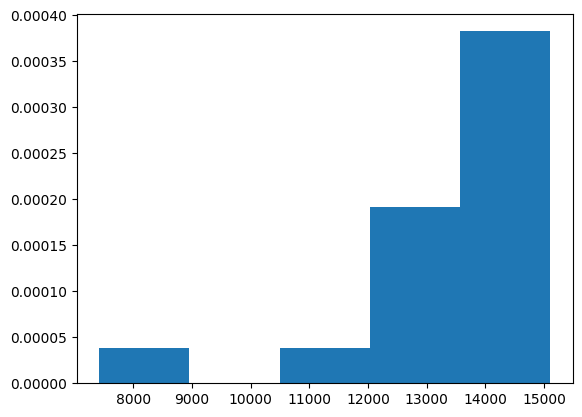

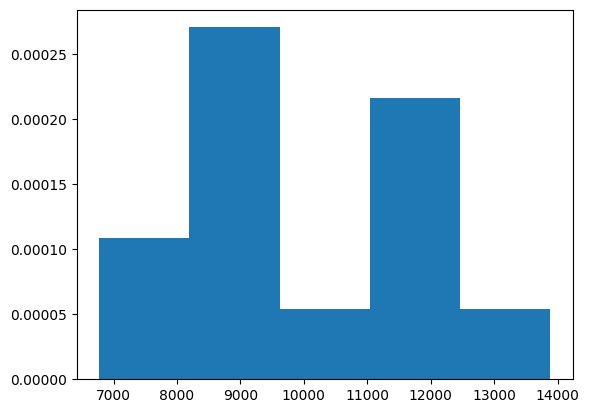

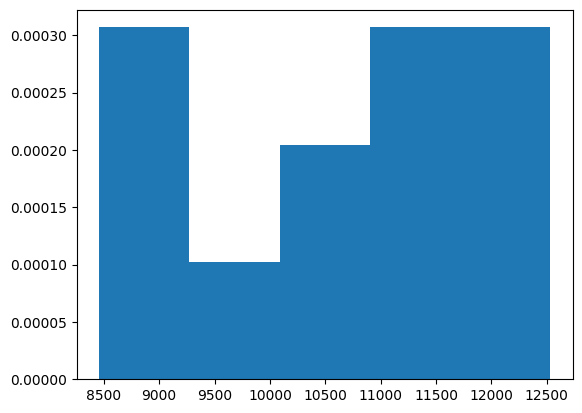

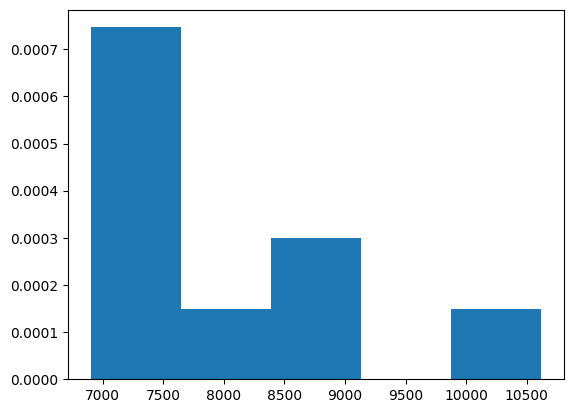

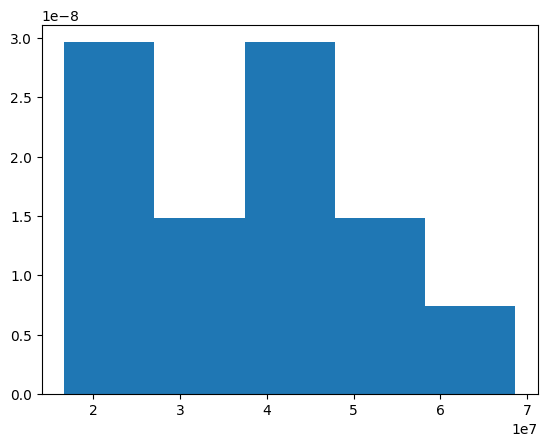

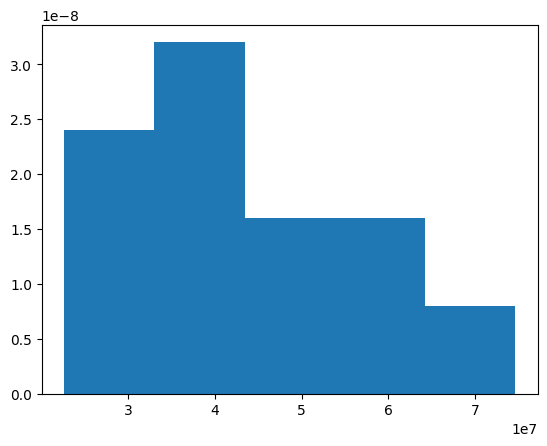

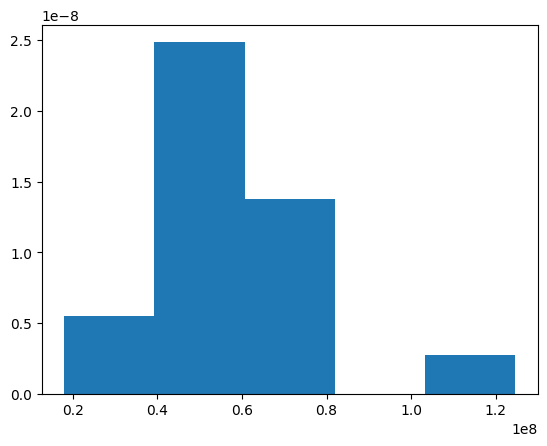

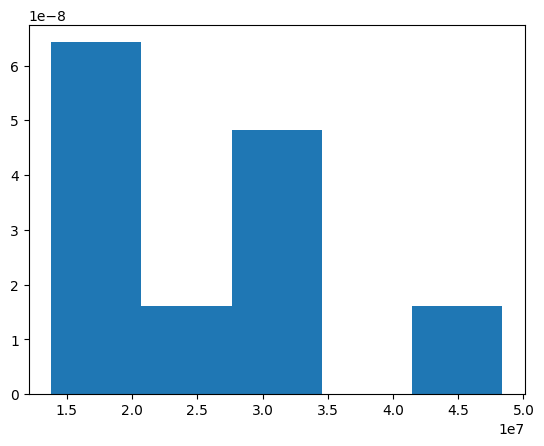

In [52]:
regions = energy[["state_name", "REGIONC"]]
regions = regions.merge(energy_state_m_v, on="state_name").groupby("state_name").agg("first")
print(regions["REGIONC"].unique())
print(len(regions)) 

plt.figure()
plt.hist(regions[regions["REGIONC"] == "SOUTH"]["state_mean"], bins=5,density=True)
plt.show()


plt.figure()
plt.hist(regions[regions["REGIONC"] == "WEST"]["state_mean"], bins=5,density=True)
plt.show()


plt.figure()
plt.hist(regions[regions["REGIONC"] == "MIDWEST"]["state_mean"], bins=5,density=True)
plt.show()


plt.figure()
plt.hist(regions[regions["REGIONC"] == "NORTHEAST"]["state_mean"], bins=5,density=True)
plt.show()

plt.figure()
plt.hist(regions[regions["REGIONC"] == "WEST"]["state_var"], bins=5,density=True)
plt.show()


plt.figure()
plt.hist(regions[regions["REGIONC"] == "MIDWEST"]["state_var"], bins=5,density=True)
plt.show()

plt.figure()
plt.hist(regions[regions["REGIONC"] == "SOUTH"]["state_var"], bins=5,density=True)
plt.show()

plt.figure()
plt.hist(regions[regions["REGIONC"] == "NORTHEAST"]["state_var"], bins=5,density=True)
plt.show()

In [55]:
energy.groupby("state_name").agg("first").groupby("DIVISION").agg("count")

,DOEID,REGIONC,STATE_FIPS,state_postal,BA_climate,IECC_climate_code,UATYP10,HDD65,CDD65,HDD30YR_PUB,...,EVCHRGHOME,EVCHRGAPT,EVCHRGWKS,EVCHRGBUS,EVCHRGMUNI,EVCHRGDLR,EVCHRGHWY,EVCHRGOTH,EVHOMEAMT,EVCHRGTYPE
DIVISION,,,,,,,,,,,,,,,,,,,,,
East North Central,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
East South Central,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
Middle Atlantic,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
Mountain North,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
Mountain South,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
New England,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
Pacific,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
South Atlantic,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
West North Central,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7


In [58]:
regions.groupby("REGIONC").agg("count")

,state_mean,state_var,state_r,state_lambda
REGIONC,,,,
MIDWEST,12,12,12,12
NORTHEAST,9,9,9,9
SOUTH,17,17,17,17
WEST,13,13,13,13


## Observed Data : Household level

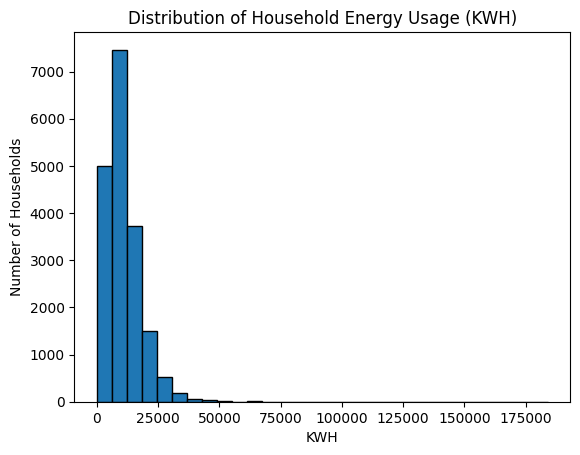

In [61]:
import matplotlib.pyplot as plt
plt.hist(energy["KWH"].dropna(), bins=30, edgecolor='black')
plt.title("Distribution of Household Energy Usage (KWH)")
plt.xlabel("KWH")
plt.ylabel("Number of Households")
plt.show()


## now lets check out the region-level distributions

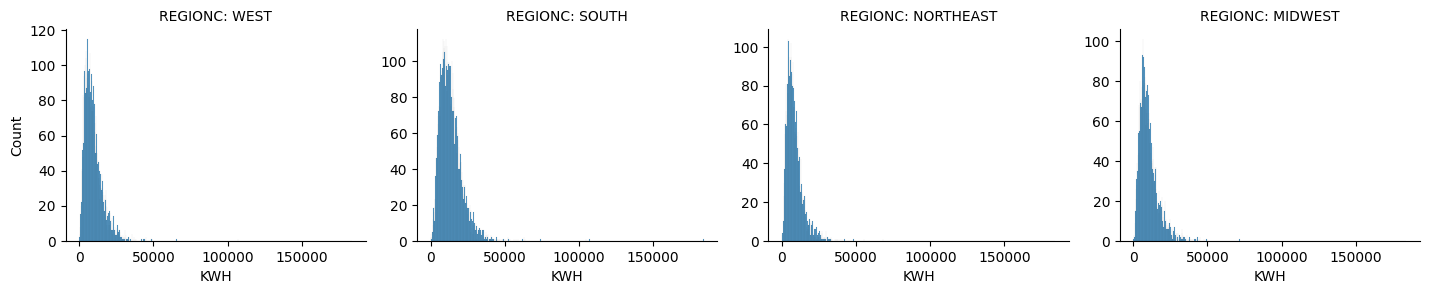

In [16]:
energy["KWH"] = pd.to_numeric(energy["KWH"], errors="coerce")
energy = energy.dropna(subset=["KWH", "REGIONC"])

g = sns.displot(
    data=energy,
    x="KWH",
    col="REGIONC",      
    col_wrap=4,  
    binwidth=250,       
    facet_kws={'sharey': False, 'sharex': True},
    height=3, aspect=1.2
)

g.set_titles("REGIONC: {col_name}")
g.set_axis_labels("KWH", "Count")
plt.subplots_adjust(top=0.9)
#g.fig.suptitle("Distribution of Household Energy Usage (KWH) by REGIONC")
plt.show()


<AxesSubplot: xlabel='KWH', ylabel='Density'>

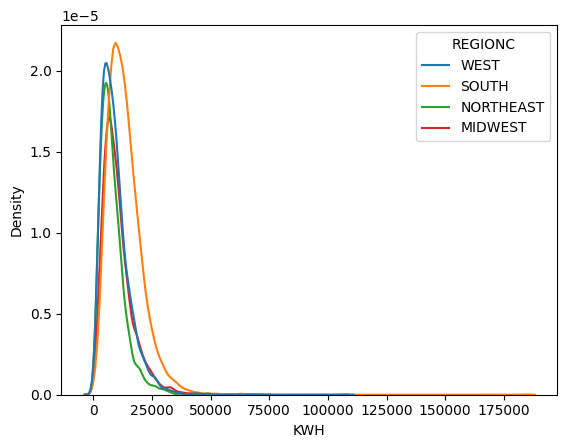

In [17]:
sns.kdeplot(data=energy, x="KWH", hue="REGIONC")


WEST's mean: 9465.055863348614
WEST's variance: 35057092.757718235
SOUTH's mean: 13513.03996109555
SOUTH's variance: 53408440.84829525
NORTHEAST's mean: 8321.23528575335
NORTHEAST's variance: 26580644.64168329
MIDWEST's mean: 10447.489024008351
MIDWEST's variance: 38187951.6508941


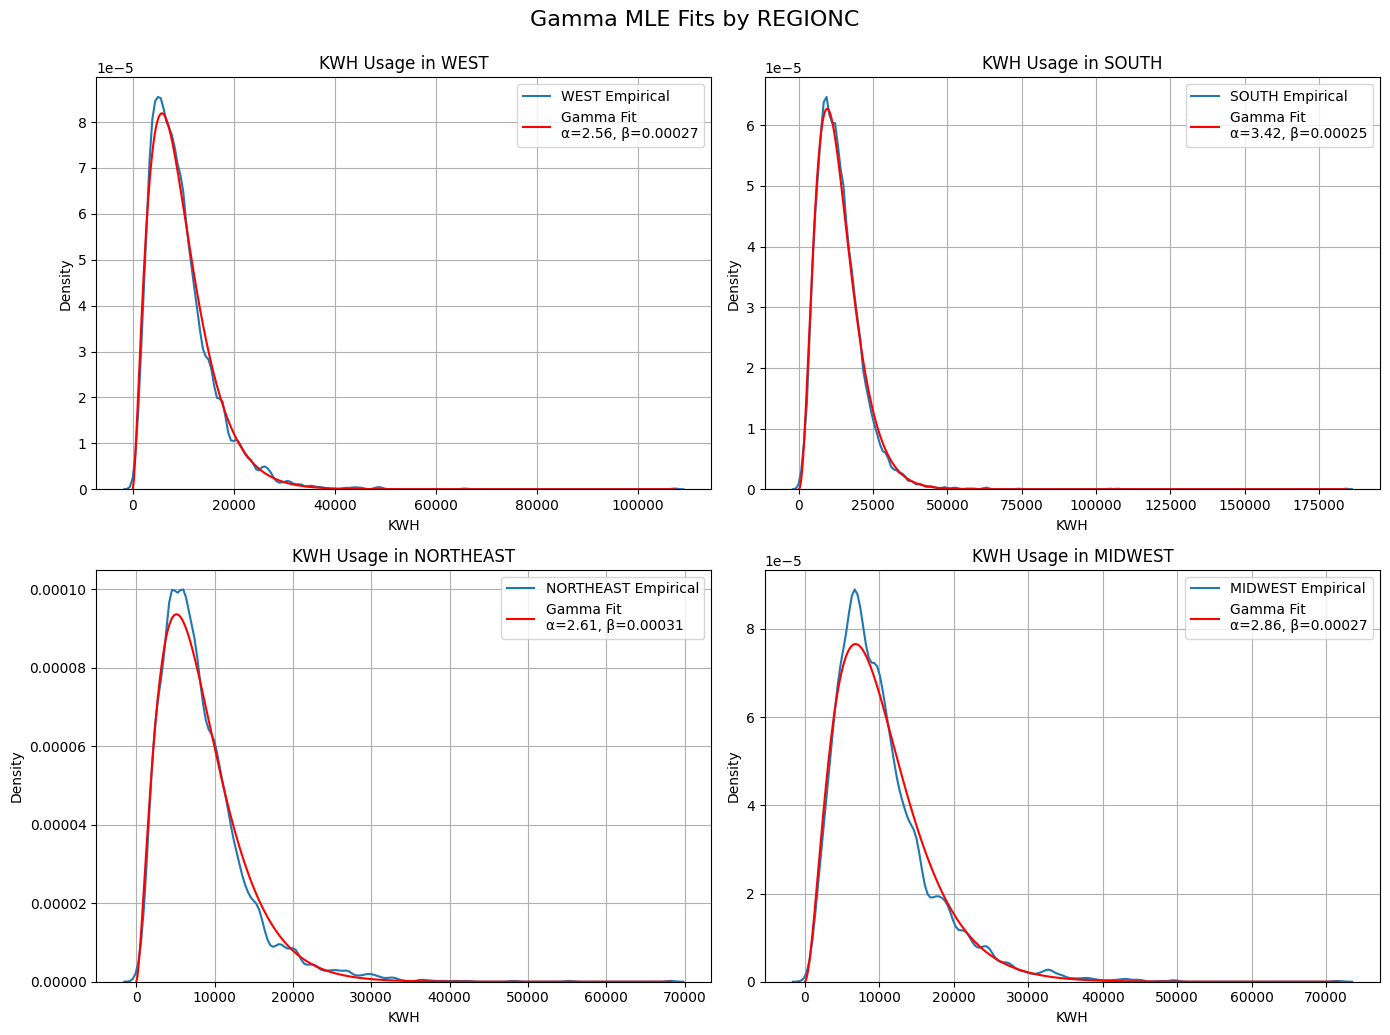

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma
df=energy
df["KWH"] = pd.to_numeric(df["KWH"], errors="coerce")
df = df.dropna(subset=["KWH", "REGIONC"])

regions = df["REGIONC"].unique()
n_regions = len(regions)

region_mus = []
region_vars = []

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, region in enumerate(regions):
    ax = axes[i]
    subset = df[df["REGIONC"] == region]["KWH"].dropna()

    
    a_hat, loc_hat, scale_hat = gamma.fit(subset, floc=0)
    beta_hat = 1 / scale_hat

    
    sns.kdeplot(subset, ax=ax, label=f"{region} Empirical", bw_adjust=0.5)

    x = np.linspace(0, subset.max(), 500)
    y = gamma.pdf(x, a=a_hat, loc=loc_hat, scale=scale_hat)
    ax.plot(x, y, 'r-', label=f"Gamma Fit\nα={a_hat:.2f}, β={beta_hat:.5f}")

    region_mean = a_hat / beta_hat
    region_var = a_hat / beta_hat**2

    region_mus.append(region_mean)
    region_vars.append(region_var)
    
    print(f"{region}'s mean: {region_mean}")
    print(f"{region}'s variance: {region_var}")

    ax.set_title(f"KWH Usage in {region}")
    ax.set_xlabel("KWH")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle("Gamma MLE Fits by REGIONC", fontsize=16, y=1.03)
plt.show()


## It looks like Gamma fits really well as priors for our Regions. Lets look at divisions now.

In [67]:
division_to_region = df.groupby("DIVISION")["REGIONC"].agg(lambda x: x.mode()[0])
print(division_to_region)
#Assign priors to divisions
priors = {
    "WEST": {"alpha": 2.56, "beta": 0.00027},
    "SOUTH": {"alpha": 3.42, "beta": 0.00025},
    "MIDWEST": {"alpha": 2.86, "beta": 0.00027},
    "NORTHEAST": {"alpha": 2.61, "beta": 0.00031}
}

division_to_region = {
    "East North Central": "MIDWEST",
    "East South Central": "SOUTH",
    "Middle Atlantic": "NORTHEAST",
    "Mountain North": "WEST",
    "Mountain South": "WEST",
    "New England": "NORTHEAST",
    "Pacific": "WEST",
    "South Atlantic": "SOUTH",
    "West North Central": "MIDWEST",
    "West South Central": "SOUTH"
}



DIVISION
East North Central      MIDWEST
East South Central        SOUTH
Middle Atlantic       NORTHEAST
Mountain North             WEST
Mountain South             WEST
New England           NORTHEAST
Pacific                    WEST
South Atlantic            SOUTH
West North Central      MIDWEST
West South Central        SOUTH
Name: REGIONC, dtype: object


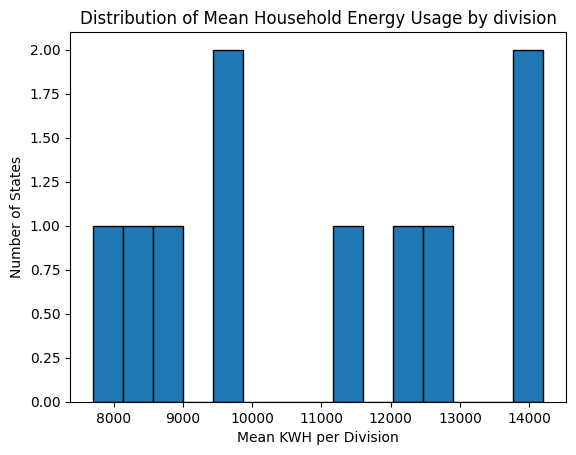

In [20]:
state_means = energy.groupby("DIVISION")["KWH"].mean()
plt.hist(state_means, bins=15, edgecolor="black")
plt.title("Distribution of Mean Household Energy Usage by division")
plt.xlabel("Mean KWH per Division")
plt.ylabel("Number of States")
plt.show()

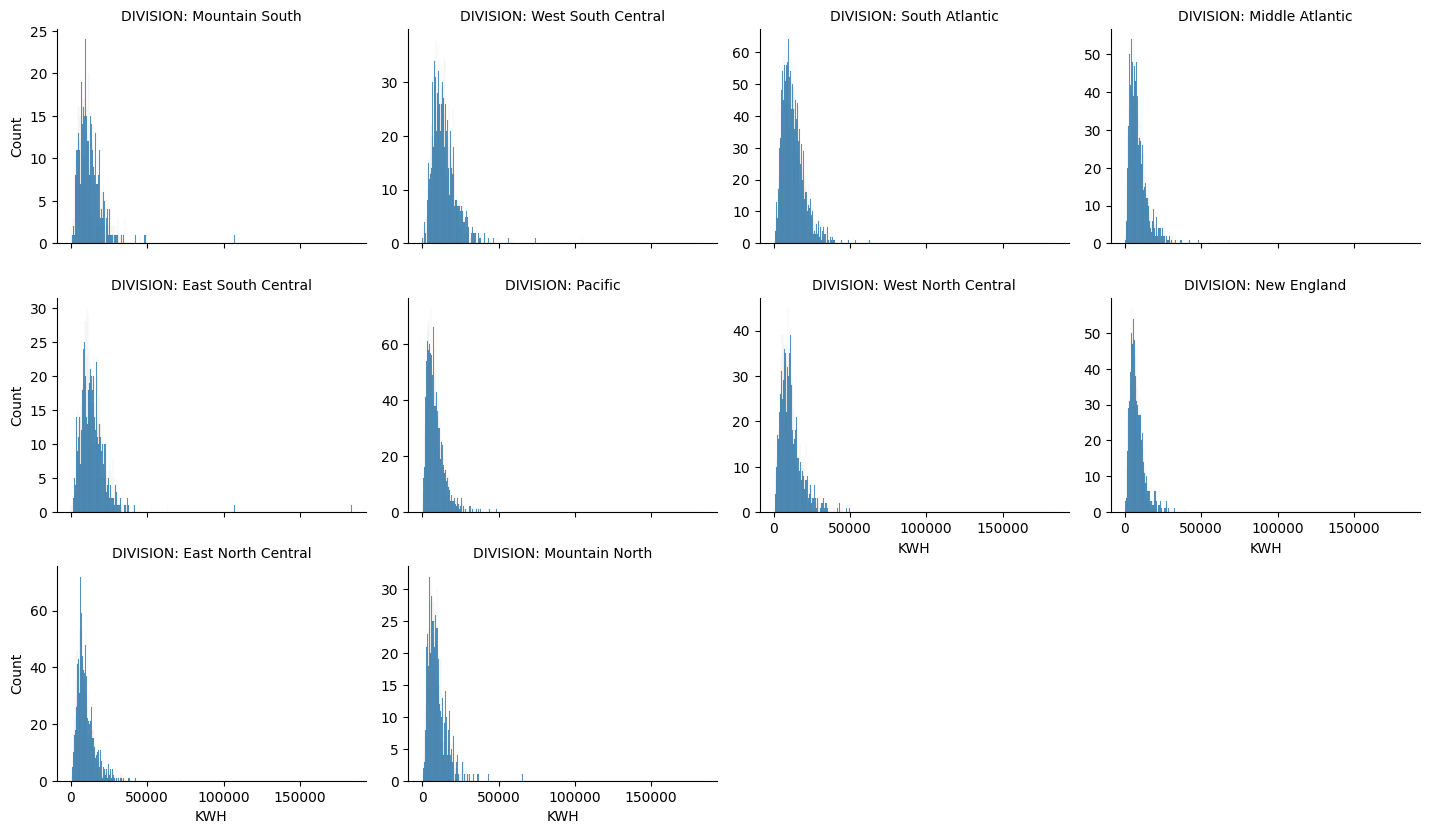

In [70]:
energy["KWH"] = pd.to_numeric(energy["KWH"], errors="coerce")
energy = energy.dropna(subset=["KWH", "DIVISION"])

g = sns.displot(
    data=energy,
    x="KWH",
    col="DIVISION",      
    col_wrap=4,  
    binwidth=250,       
    facet_kws={'sharey': False, 'sharex': True},
    height=3, aspect=1.2
)

g.set_titles("DIVISION: {col_name}")
g.set_axis_labels("KWH", "Count")
plt.subplots_adjust(top=0.9)
#g.fig.suptitle("Distribution of Household Energy Usage (KWH) by REGIONC")
plt.show()


Based on the plots above, we think the divisions should follow a normal distribution. The histogram of Mean KWH per division is sort of symmetric and spans a wide range of values. We think Division ~ Normal(mu_region, var_region) 

## State Level analysis

In [22]:
# first make sure all states clearly map to a division code


state_to_division_idx = df.drop_duplicates("state_name")[["state_name", "DIVISION"]].sort_values("state_name")["DIVISION"].values
print(state_to_division_idx)

['East South Central' 'Pacific' 'Mountain South' 'West South Central'
 'Pacific' 'Mountain North' 'New England' 'South Atlantic'
 'South Atlantic' 'South Atlantic' 'South Atlantic' 'Pacific'
 'Mountain North' 'East North Central' 'East North Central'
 'West North Central' 'West North Central' 'East South Central'
 'West South Central' 'New England' 'South Atlantic' 'New England'
 'East North Central' 'West North Central' 'East South Central'
 'West North Central' 'Mountain North' 'West North Central'
 'Mountain South' 'New England' 'Middle Atlantic' 'Mountain South'
 'Middle Atlantic' 'South Atlantic' 'West North Central'
 'East North Central' 'West South Central' 'Pacific' 'Middle Atlantic'
 'New England' 'South Atlantic' 'West North Central' 'East South Central'
 'West South Central' 'Mountain North' 'New England' 'South Atlantic'
 'Pacific' 'South Atlantic' 'East North Central' 'Mountain North']


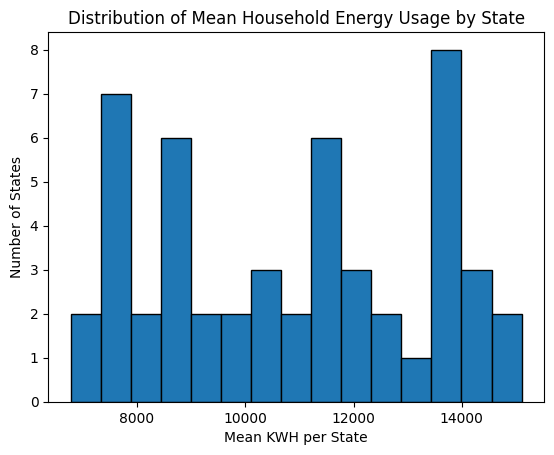

In [23]:
state_means = energy.groupby("state_name")["KWH"].mean()
plt.hist(state_means, bins=15, edgecolor="black")
plt.title("Distribution of Mean Household Energy Usage by State")
plt.xlabel("Mean KWH per State")
plt.ylabel("Number of States")
plt.show()


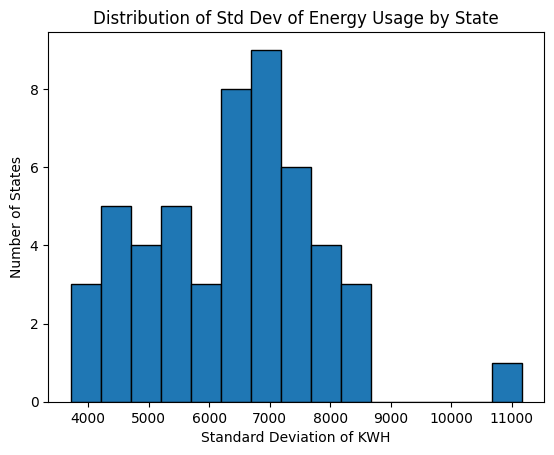

In [24]:
state_stds = energy.groupby("state_name")["KWH"].std()
plt.hist(state_stds, bins=15, edgecolor="black")
plt.title("Distribution of Std Dev of Energy Usage by State")
plt.xlabel("Standard Deviation of KWH")
plt.ylabel("Number of States")
plt.show()


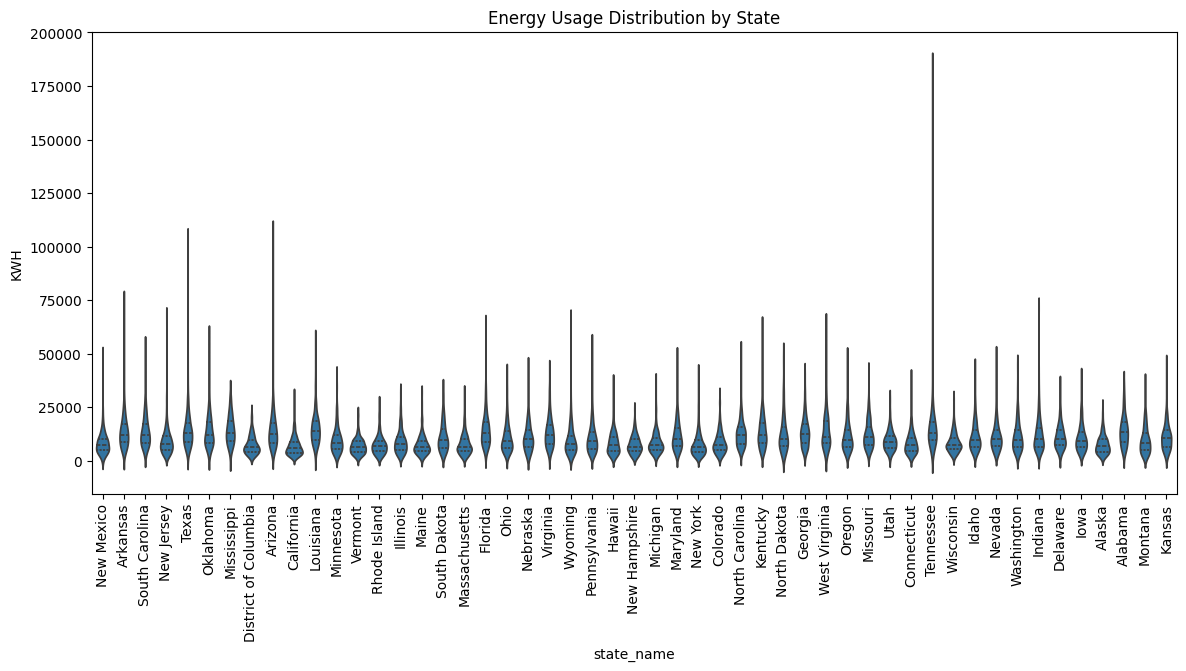

In [25]:
plt.figure(figsize=(14, 6))
sns.violinplot(data=energy, x="state_name", y="KWH", inner="quartile")
plt.xticks(rotation=90)
plt.title("Energy Usage Distribution by State")
plt.show()


Based on the plots above, we observe that household energy usage within each state appears roughly normally distributed, but with some states exhibiting significantly more variance than others. Additionally, several states show a heavy right tail due to extreme high usage households. To account for this heavy tailed behavior, we choose a Student-t distribution for modeling household energy usage. This allows us to retain a symmetric, mean-centered distribution while being more robust to outliers than a standard normal distribution.



### Division Level Mean and Variance

In [26]:
#sierra
# aggregate states and look at division level distribution

state_kwh = energy.groupby("state_name")["KWH"].mean().reset_index()
state_kwh.columns = ["state_name", "mean_kwh"]
state_division = energy[["state_name", "DIVISION"]].drop_duplicates()
state_kwh = pd.merge(state_kwh, state_division, on="state_name", how="left")
division_summary = state_kwh.groupby("DIVISION")["mean_kwh"].agg(["mean", "var"]).reset_index()
division_summary.columns = ["division", "state_mean_kwh", "state_var_kwh"]

print(division_summary)


             division  state_mean_kwh  state_var_kwh
0  East North Central     9736.606035   2.348282e+06
1  East South Central    14217.187806   3.171072e+05
2     Middle Atlantic     9061.579822   2.322881e+06
3      Mountain North     9641.440724   9.807721e+05
4      Mountain South    11240.138763   7.649846e+06
5         New England     7618.474431   2.776060e+05
6             Pacific     9079.279825   4.447107e+06
7      South Atlantic    12435.708463   4.447864e+06
8  West North Central    11279.721383   8.849070e+05
9  West South Central    14181.619380   3.886011e+05


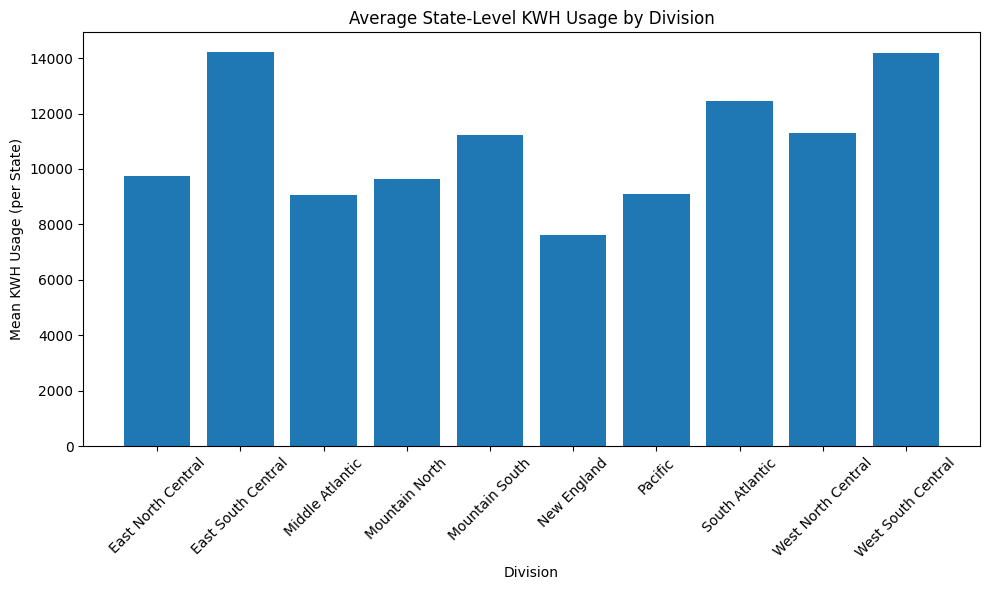

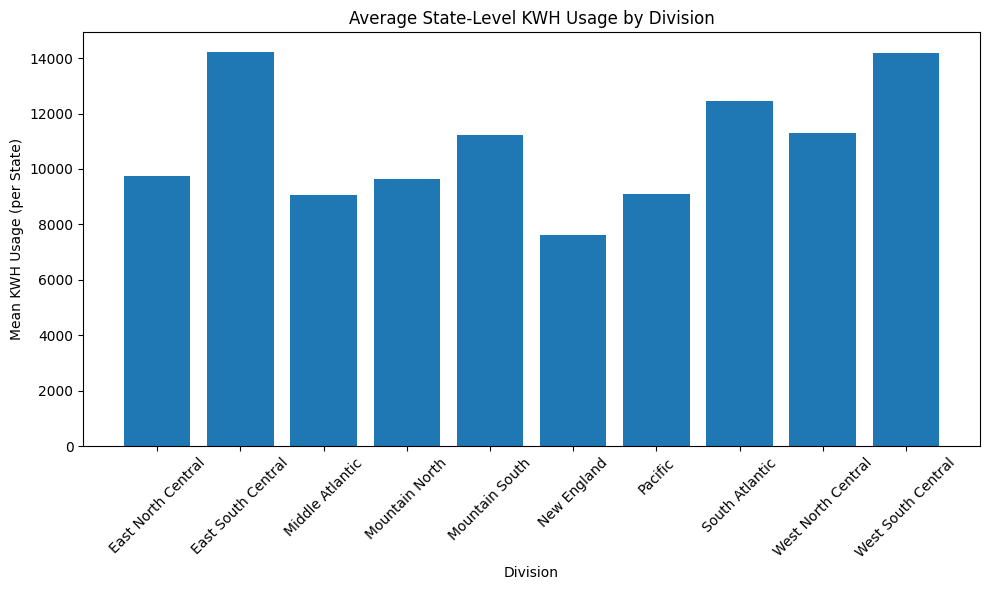

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(division_summary["division"], division_summary["state_mean_kwh"])

plt.xlabel("Division")
plt.ylabel("Mean KWH Usage (per State)")
plt.title("Average State-Level KWH Usage by Division")
plt.xticks(rotation=45)
plt.tight_layout()


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(division_summary["division"], division_summary["state_mean_kwh"])

plt.xlabel("Division")
plt.ylabel("Mean KWH Usage (per State)")
plt.title("Average State-Level KWH Usage by Division")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Working Model

In [73]:
state_idx = energy['state_name'].astype('category').cat.codes
region_idx = energy['REGIONC'].astype('category').cat.codes

region_to_state = energy[["state_name", "REGIONC"]].groupby("state_name").agg("first")

energy_state_means = energy[['state_name', 'KWH']].groupby('state_name').agg('mean')
energy_region_means = energy_state_means.merge(region_to_state, on="state_name").groupby('REGIONC').agg('var')
energy_region_means = energy_region_means["KWH"].to_numpy()

energy_state_vars = energy[['state_name', 'KWH']].groupby('state_name').agg('var')
energy_region_vars = energy_state_vars.merge(region_to_state, on="state_name").groupby('REGIONC').agg('var')
energy_region_vars["KWH"] = np.sqrt(energy_region_vars["KWH"])
energy_region_vars = energy_region_vars["KWH"].to_numpy()

num_regions = len(energy['REGIONC'].unique())
num_states = len(energy['state_name'].unique())

def approx_inf():

    with pm.Model() as model:

        #hyperparameters 
        top_mu = pm.Uniform("top_mu", lower= 5000 , upper= 20000) # we can set a range due to a relatively small range of values
        top_var = pm.HalfFlat("top_var") # the range of values is huge so we will just use a half Flat as variance cannot be negative
        
        # region level
        # multiply sd by 10 to spread out distribution to make it more normal 
        # variances are observed values 
        # mu is sampled from hyperparameters
        #mu_state = pm.Normal("mu_state", mu = top_mu, sigma = energy_region_means[region_idx]*10, shape=num_regions)
        #var_state = pm.Normal("var_state", mu = top_var, sigma = energy_region_vars[region_idx]*10, shape=num_regions)

        mu_region = pm.Normal("mu_region", mu=top_mu, sigma=energy_region_means * 10, shape=num_regions)
        var_region = pm.Normal("var_region", mu=top_var, sigma=energy_region_vars * 10, shape=num_regions)
        
        # State level (now depending on regions)
        mu_state = mu_region[region_idx]  # Region-level means for each state
        var_state = var_region[region_idx]  # Region-level variances for each state

        # states le
        # deterministic just turns the mu and var into alpha/beta
        alpha_state = pm.Deterministic("alpha_state", mu_state**2 / var_state)
        beta_state = pm.Deterministic("beta_state", mu_state / var_state)

        #state level
        household = pm.Gamma("household", 
                            alpha=alpha_state[state_idx],
                            beta=beta_state[state_idx],
                            #shape=num_states,
                            observed=energy['KWH'])#[['state_name', 'KWH']].groupby('state_name').agg('mean')['KWH'])

        print("made it")

        rng = np.random.default_rng(0)

        trace = pm.sample(1000, chains=4, tune=100, return_inferencedata=True, random_seed=rng)

    return (model,trace)

In [76]:
model, trace = approx_inf()

made it
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [top_mu, top_var, mu_region, var_region]


/root/venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 55 seconds.
There were 157 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [79]:
trace["posterior"]

<xarray.Dataset> Size: 1GB
Dimensions:            (chain: 4, draw: 1000, mu_region_dim_0: 4,
                        var_region_dim_0: 4, alpha_state_dim_0: 18496,
                        beta_state_dim_0: 18496)
Coordinates:
  * chain              (chain) int64 32B 0 1 2 3
  * draw               (draw) int64 8kB 0 1 2 3 4 5 ... 994 995 996 997 998 999
  * mu_region_dim_0    (mu_region_dim_0) int64 32B 0 1 2 3
  * var_region_dim_0   (var_region_dim_0) int64 32B 0 1 2 3
  * alpha_state_dim_0  (alpha_state_dim_0) int64 148kB 0 1 2 ... 18494 18495
  * beta_state_dim_0   (beta_state_dim_0) int64 148kB 0 1 2 ... 18494 18495
Data variables:
    mu_region          (chain, draw, mu_region_dim_0) float64 128kB 5.356e+03...
    var_region         (chain, draw, var_region_dim_0) float64 128kB 1.788e+0...
    top_mu             (chain, draw) float64 32kB 1.319e+04 ... 1.119e+04
    top_var            (chain, draw) float64 32kB 8.131e+05 8.985e+05 ... 6.248
    alpha_state        (chain, draw, alpha_state_dim_0) float64 592MB 1.267e+...
    beta_state         (chain, draw, beta_state_dim_0) float64 592MB 0.2388 ....
Attributes:
    created_at:                 2025-05-13T00:11:22.325541+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.22.0
    sampling_time:              54.910884618759155
    tuning_steps:               100

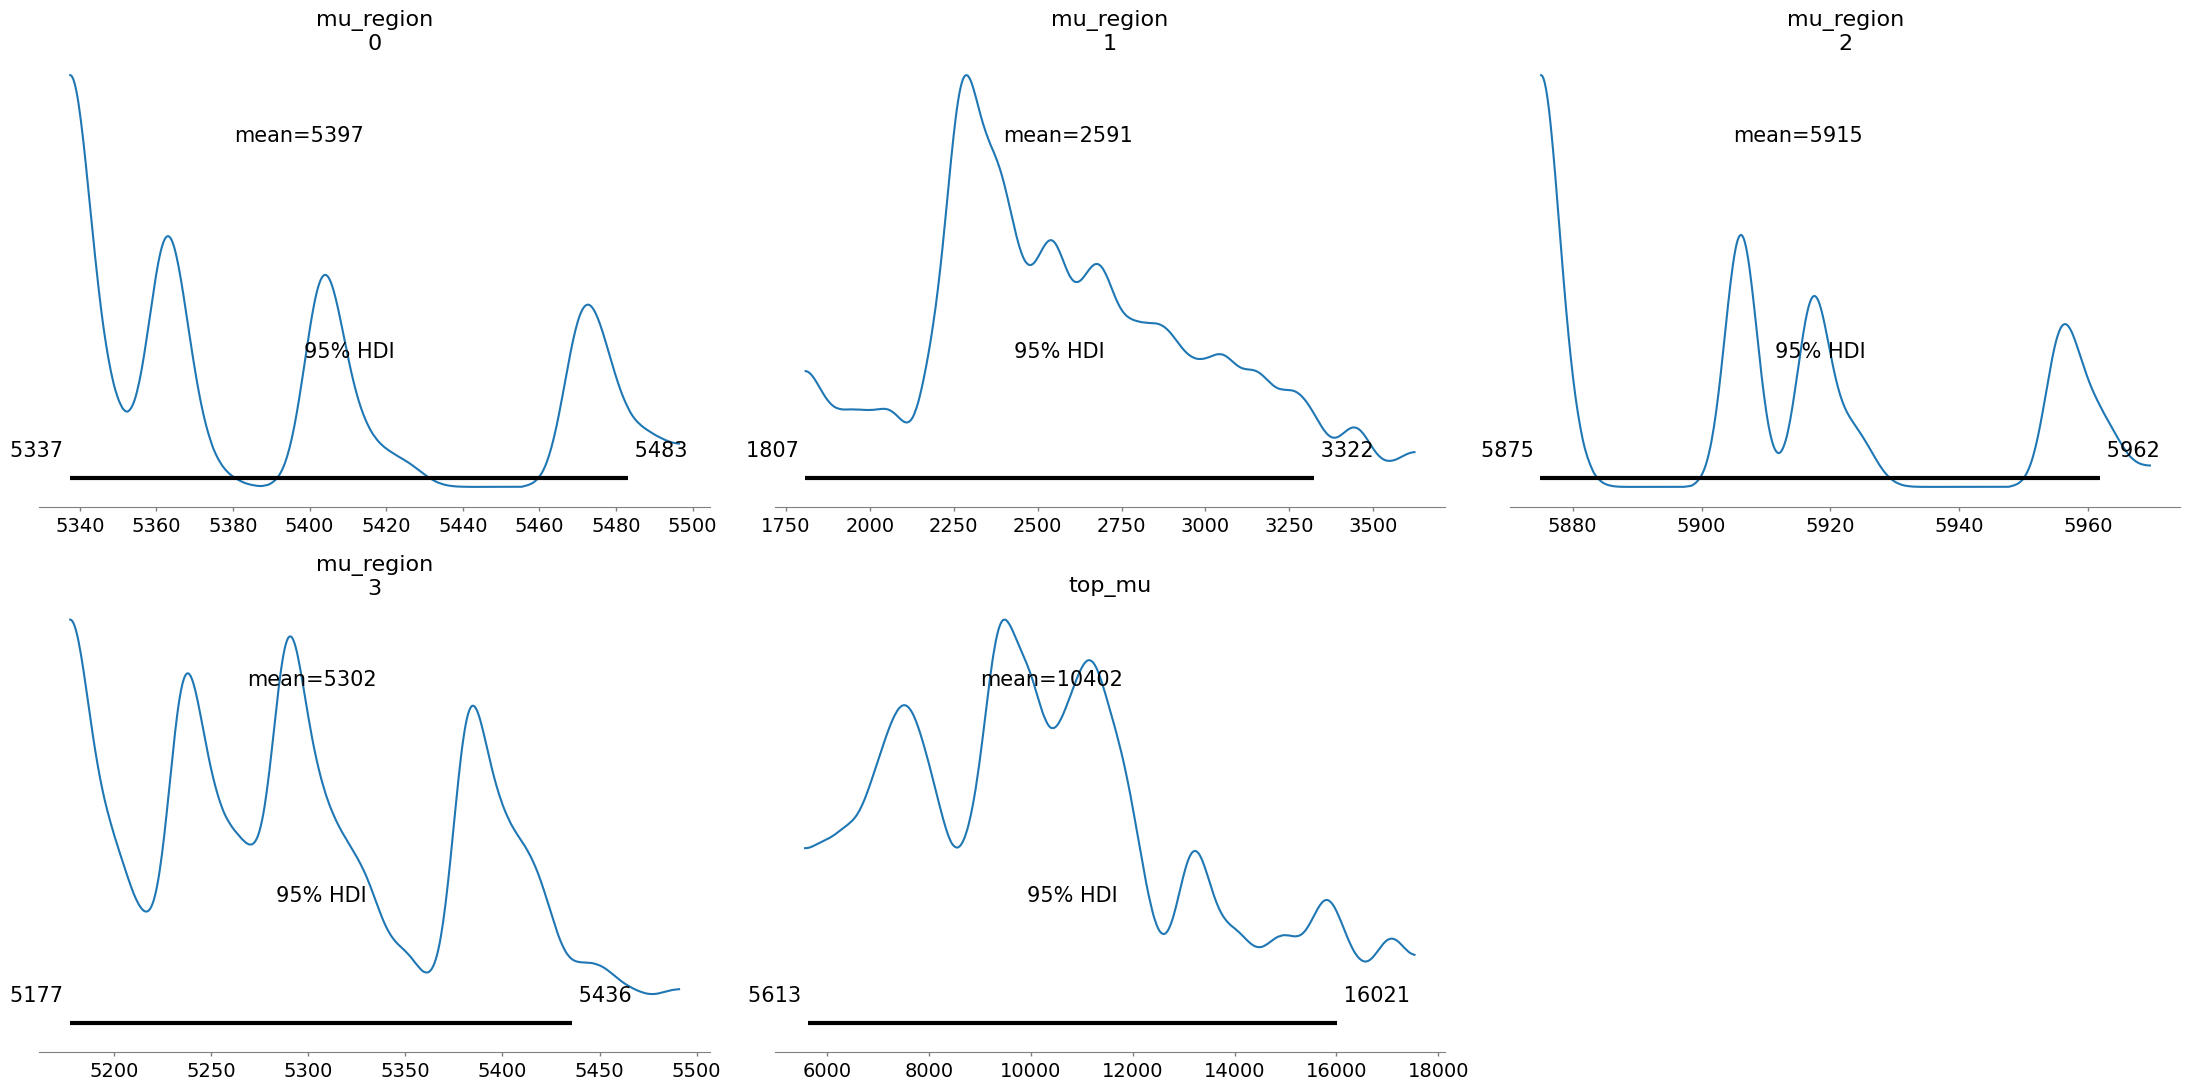

In [82]:
az.plot_posterior(trace, var_names=["mu_region", "top_mu"],hdi_prob=0.95)
plt.tight_layout()

## Testing Hyperparameter Sensitvity 

### 1. We changed our top_mu variable from a lower bound of 5000 to 0 and an upper bound of 20000 to 50000. Basically making a much larger distribution.
### 2. We changed our top_mu variable from a lower bound of 5000 to 7000 and an upper bound of 20000 to 15000. Basically making a smaller distribution.

In [85]:
state_idx = energy['state_name'].astype('category').cat.codes
region_idx = energy['REGIONC'].astype('category').cat.codes

region_to_state = energy[["state_name", "REGIONC"]].groupby("state_name").agg("first")

energy_state_means = energy[['state_name', 'KWH']].groupby('state_name').agg('mean')
energy_region_means = energy_state_means.merge(region_to_state, on="state_name").groupby('REGIONC').agg('var')
energy_region_means = energy_region_means["KWH"].to_numpy()

energy_state_vars = energy[['state_name', 'KWH']].groupby('state_name').agg('var')
energy_region_vars = energy_state_vars.merge(region_to_state, on="state_name").groupby('REGIONC').agg('var')
energy_region_vars["KWH"] = np.sqrt(energy_region_vars["KWH"])
energy_region_vars = energy_region_vars["KWH"].to_numpy()

num_regions = len(energy['REGIONC'].unique())
num_states = len(energy['state_name'].unique())

def approx_inf_adj():

    with pm.Model() as model:

        #hyperparameters 
        top_mu = pm.Uniform("top_mu", lower= 7000, upper= 15000) # we can set a range due to a relatively small range of values
        top_var = pm.HalfFlat("top_var") # the range of values is huge so we will just use a half Flat as variance cannot be negative
        
        # region level
        # multiply sd by 10 to spread out distribution to make it more normal 
        # variances are observed values 
        # mu is sampled from hyperparameters
        #mu_state = pm.Normal("mu_state", mu = top_mu, sigma = energy_region_means[region_idx]*10, shape=num_regions)
        #var_state = pm.Normal("var_state", mu = top_var, sigma = energy_region_vars[region_idx]*10, shape=num_regions)

        mu_region = pm.Normal("mu_region", mu=top_mu, sigma=energy_region_means * 10, shape=num_regions)
        var_region = pm.Normal("var_region", mu=top_var, sigma=energy_region_vars * 10, shape=num_regions)
        
        # State level (now depending on regions)
        mu_state = mu_region[region_idx]  # Region-level means for each state
        var_state = var_region[region_idx]  # Region-level variances for each state

        # states le
        # deterministic just turns the mu and var into alpha/beta
        alpha_state = pm.Deterministic("alpha_state", mu_state**2 / var_state)
        beta_state = pm.Deterministic("beta_state", mu_state / var_state)

        #state level
        household = pm.Gamma("household", 
                            alpha=alpha_state[state_idx],
                            beta=beta_state[state_idx],
                            #shape=num_states,
                            observed=energy['KWH'])#[['state_name', 'KWH']].groupby('state_name').agg('mean')['KWH'])

        print("made it")

        trace = pm.sample(1000, chains=4, tune=100, return_inferencedata=True)

    return (model,trace)

In [88]:

model_adj, trace_adj = approx_inf_adj()

made it
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [top_mu, top_var, mu_region, var_region]


/root/venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 58 seconds.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Plot Posterior

In [91]:
def plot_posterior_mu_region(trace, region_names, **kwargs):

    #Code from hwk 2
    #Shows distribution of posterior means from a PyMC trace.
    
    num_regions = len(region_names)
    mu_array = trace.posterior['mu_region'].values.reshape(-1, len(region_names))
    means_wide = pd.DataFrame(mu_array, columns=region_names)
    means_long = pd.melt(means_wide, var_name='region_names', value_name='Posterior mean')
    sns.histplot(means_long, x='Posterior mean', hue='region_names', bins=np.linspace(0, 14000, 500))
    plt.xlim(1000, 6500)
    plt.title("Posterior Means of the Region")

### Plot of the Posterior of the Original Model

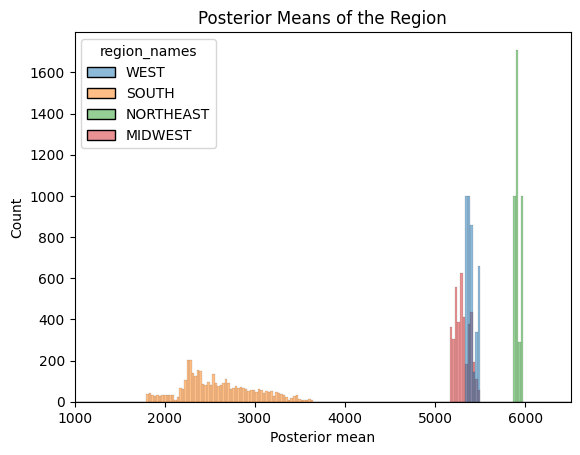

In [94]:
plot_posterior_mu_region(trace, energy['REGIONC'].unique())

### Plot of the Posterior of the Adjusted Model (Changed Hyperparameters)

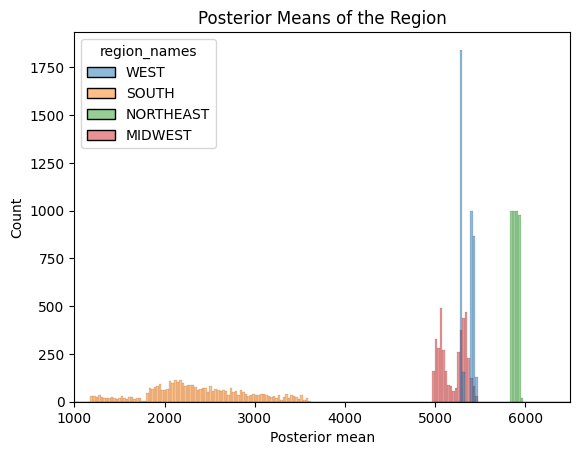

In [97]:
plot_posterior_mu_region(trace_adj, energy['REGIONC'].unique())

## Model Evaluation

In [100]:

with model:
    ppc = pm.sample_posterior_predictive(trace)
# Find Residual

Sampling: [household]


/root/venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [ ]:
# 4 chains, 1000 samples per chain, take mean of 4000 values to get predicted value 
residuals = energy['KWH'] - ppc['posterior_predictive']['household'].mean(dim=("chain", "draw")).values
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")

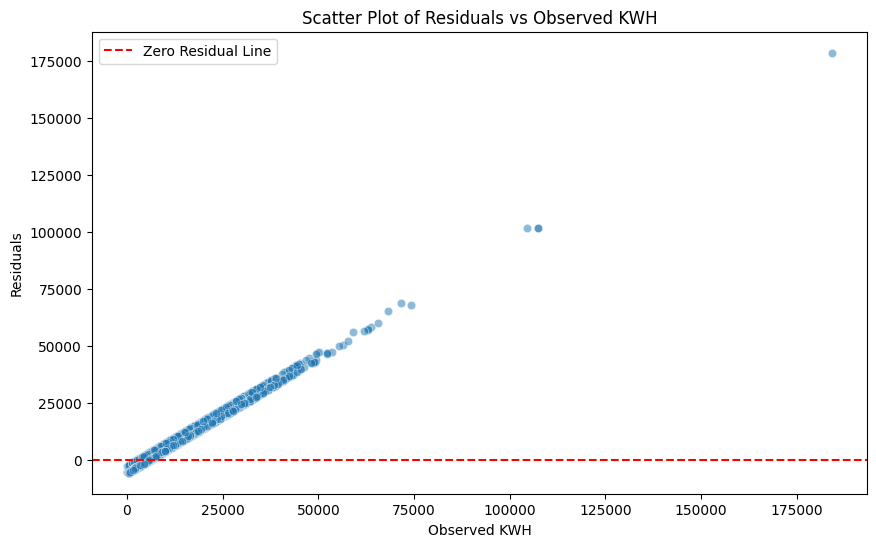

In [41]:

residuals = energy['KWH'] - ppc['posterior_predictive']['household'].mean(dim=("chain", "draw")).values

# scatter plot 
plt.figure(figsize=(10, 6))
sns.scatterplot(x=energy['KWH'], y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.title("Scatter Plot of Residuals vs Observed KWH")
plt.xlabel("Observed KWH")
plt.ylabel("Residuals")
plt.legend()

Text(0.5, 0, 'Residuals (Observed - Predicted KWH)')

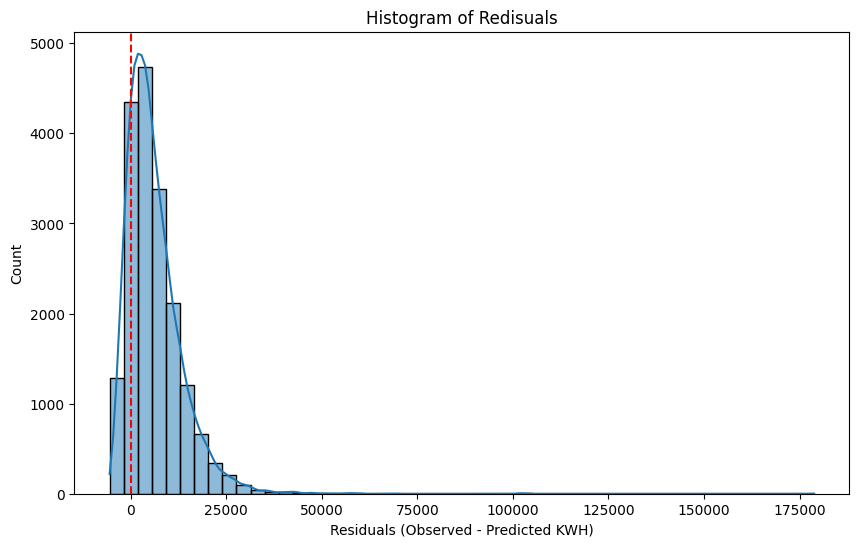

In [42]:
#histogram of residuals

import matplotlib.pyplot as plt
import seaborn as sns
residuals = energy['KWH'] - ppc['posterior_predictive']['household'].mean(dim=("chain", "draw")).values

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.title('Histogram of Redisuals')
plt.xlabel("Residuals (Observed - Predicted KWH)")


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e7c7e5ea-85f8-4ba1-a144-22a3b75e26c3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>